## Generating Video with Detected Lane Lines
---
The overall pipeline of the algorithm can be found in the following notebook.: [`pipeline.ipynb`](./pipeline.ipynb)



Following custom utility functions are used.

* **CameraCalibration**: From 6x9 check board images, calibration-related parameters or images are calculated.
* **ImageColorThres**: Color thresholding related. it uses HSV color map.
* **gradThres**: gradient thresholding related. it uses sobel operator.
* **PerspectiveTransform**: From destination and source points, perspective transform and inverse perspective transform is calculated.
* **FindLaneLine**: From warped image through perspective transform, it finds lane lines. The pixel detected as lane lines are fitted to the 2nd order polynomial function.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Import custom utility functions
from utils.CameraCalibration import CameraCalibration # import Calibaration
from utils.Thresholding import ImageColorThres
import utils.GradientThresholding as gradThres
from utils.PerspectiveTransform import PerspectiveTransform
from utils.FindLaneLine import *

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
# camera calibration using 6x9 checkboards
chkboard_images = glob.glob('./camera_cal/calibration*.jpg')
calibration = CameraCalibration(chkboard_images)

In [3]:
def process_image_test(img, debug=False):
    undimg = calibration.undistort_img(img)

    imshape = undimg.shape # image size
    roi_vertices = np.array([[(0,imshape[0]), 
                            (imshape[1]*7/15, imshape[0]*3/5), 
                            (imshape[1]*8/15, imshape[0]*3/5), 
                            (imshape[1],imshape[0])]], 
                             dtype=np.int32) # vertices of roi
    
    
    # -------------------------------------------------------------
    # Color Thresholds
    # -------------------------------------------------------------
    colorthres = ImageColorThres(img, roi_vertices)

#     yellowline = colorthres.thresholding_onechannel('R', 150, 250) # yellow for S channel
#     whiteline  = colorthres.thresholding_onechannel('L', 170, 255) # white for L channel
    
    
    R_ = colorthres.img[:,:,0]
    G_ = colorthres.img[:,:,1]
    B_ = colorthres.img[:,:,2]
    
    hls = cv2.cvtColor(undimg, cv2.COLOR_RGB2HLS)
    S_ = colorthres.S

    com = R_/255 * S_/255
    comw = R_/255 * G_/255 * B_/255
    
    yellowline = np.zeros_like(R_)
#     yellowline[(com > 0.65) & (com < 0.8)] = 1
    yellowline[com > 0.70] = 1
    
    whiteline = np.zeros_like(R_)
    whiteline[comw > 0.63] = 1
    
    
    binary_color = np.zeros_like(yellowline)
    binary_color = np.maximum(yellowline, whiteline) # combine white and yellow using maximum

    
    # -------------------------------------------------------------
    # Gradient Thresholds
    # -------------------------------------------------------------
    # use red image as gradient threhold input
    redimg = undimg[:,:,0]
    redimg_blur = gradThres.gaussian_blur(redimg, 3)
    
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = gradThres.abs_sobel_thresh(redimg_blur, orient='x', sobel_kernel=ksize, thresh=(50, 200))
    grady = gradThres.abs_sobel_thresh(redimg_blur, orient='y', sobel_kernel=ksize, thresh=(50, 200))

    # Combine gradient and trim roi
    combined = np.zeros_like(gradx)
    combined[((gradx == 1) & (grady == 1))] = 1
    binary_grad = gradThres.region_of_interest(combined, roi_vertices)

    # Combine color and gradient thresholds
    finimg = np.zeros_like(redimg)
    finimg[(binary_grad == 1) | (binary_color ==1)] = 1
    
    # -------------------------------------------------------------
    # Perspective Transform
    # -------------------------------------------------------------
    perspective = PerspectiveTransform(finimg)
    binary_warped = perspective.warp_image(finimg)
    
    # -------------------------------------------------------------
    # Find lane lines
    # -------------------------------------------------------------
    if process_image_test.first == True:
        out_img, window_img, result, left_fit, right_fit, left_curverad, right_curverad, cte = window_search(binary_warped, nwindows=9)
        process_image_test.left_fit = left_fit
        process_image_test.right_fit = right_fit
        process_image_test.first = False
        
    else:
        out_img, window_img, result, left_fit, right_fit, left_curverad, right_curverad, cte = window_search(binary_warped, nwindows=9, margin=70,
                                                                             left_fit=process_image_test.left_fit,
                                                                             right_fit=process_image_test.right_fit, 
                                                                             first_time=False)
        process_image_test.left_fit = left_fit
        process_image_test.right_fit = right_fit
        

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # -------------------------------------------------------------
    # Draw
    # -------------------------------------------------------------
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective.unwarp_image(color_warp)

    # Combine the result with the original image
    result = cv2.addWeighted(undimg, 1, newwarp, 0.3, 0)
    
    # Write text (cte, radius of curvature) on image
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, 'CTE: %.3f(m)' %(cte) ,(50,90), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result, 'Radius of curvature: %.1f, %.1f(m)' %(left_curverad, right_curverad) ,(50,140), font, 1,(255,255,255),2,cv2.LINE_AA)
    plt.imshow(result)
    if debug == False:
        return result
    else:
        return binary_color, binary_grad, binary_warped, result, yellowline, whiteline

process_image_test.left_fit = None
process_image_test.right_fit = None
process_image_test.first = True

[MoviePy] >>>> Building video output_video_.mp4
[MoviePy] Writing video output_video_.mp4


100%|█████████▉| 1260/1261 [03:25<00:00,  6.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video_.mp4 

CPU times: user 5min 20s, sys: 4.36 s, total: 5min 24s
Wall time: 3min 25s


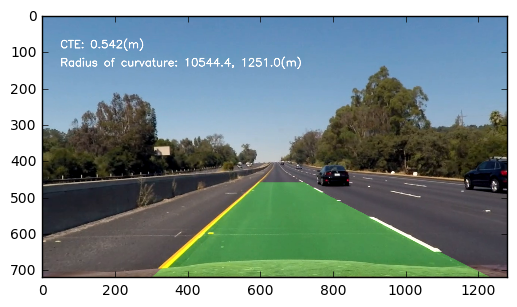

In [4]:
white_output = 'output_video_.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image_test) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)